# Data query notebook

This notebook's purpose is to query the relevant data for this project's operation from OpenStreetMap's database and save it to the `geodata/` folder in the GeoJSON format, primarily so it doesn't have to be re-queried (and re-prepared) every single time we run the backend.

You can grab these dependencies with Poetry, using the settings from `backend/`, as in (from the project's root):
```
poetry -P backend/ run jupyter notebook --notebook-dir=notebooks/
```

In [170]:
# Imports
from OSMPythonTools.api import Api
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
from OSMPythonTools.nominatim import Nominatim
import geopandas as gpd
import shapely

## 1. Querying the data from OSM

In [171]:
overpass = Overpass()
api = Api()
nominatim = Nominatim()

In [172]:
areaId = nominatim.query('Medellín, Colombia').areaId()
areaId

3601343264

In [173]:
comunas_raw = overpass.query(overpassQueryBuilder(
    area=areaId, elementType='relation', selector='"admin_level"=8', out='body', includeGeometry=True
))
comunas_raw

In [174]:
police_stations_raw = overpass.query(overpassQueryBuilder(
    area=areaId, elementType='nw', selector='"amenity"="police"', out='body', includeGeometry=True
))
police_stations_raw

In [175]:
barrios_raw = overpass.query(overpassQueryBuilder(
    area=areaId, elementType='node', selector='"place"="neighbourhood"', out='body', includeGeometry=True
))
barrios_raw

In [176]:
# Some of them are nodes, others are ways describing the shape of police stations themselves, we'll fix that later
[el.type() for el in police_stations_raw.elements()]

['node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'node',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way',
 'way']

## 2. Data preparation
The raw data isn't on GeoJSON yet, and we'll have to do some filtering and processing for the police stations specially.
We'll use the power of GeoPandas for all of this.

In [177]:
# Constructing the dataframes
com_data = gpd.GeoDataFrame([{
    'geometry': shapely.from_geojson(str(el.geometry())),
    **el.tags()
} for el in comunas_raw.elements()])
# voilá (after a long time)
com_data.head()

,geometry,admin_level,boundary,is_in:city,name,place,ref,type,wikipedia,short_name,wikidata
0,"POLYGON ((-75.55588 6.24595, -75.55652 6.24536...",8,administrative,Medellín,Comuna 9 - Buenos Aires,suburb,9,boundary,es:Buenos Aires (Medellín),NaN,NaN
1,"POLYGON ((-75.57209 6.26516, -75.5728 6.2627, ...",8,administrative,Medellín,Comuna 10 - La Candelaria,suburb,10,boundary,es:La Candelaria (Medellín),NaN,NaN
2,"POLYGON ((-75.58086 6.19699, -75.58089 6.19692...",8,administrative,Medellín,Comuna 14 - El Poblado,suburb,14,boundary,es:El Poblado (Medellín),NaN,NaN
3,"POLYGON ((-75.59996 6.20014, -75.59922 6.20014...",8,administrative,Medellín,Comuna 16 - Belén,suburb,16,boundary,es:Belén (Medellín),NaN,NaN
4,"POLYGON ((-75.59894 6.19694, -75.59894 6.19647...",8,administrative,Medellín,Comuna 15 - Guayabal,suburb,15,boundary,es:Guayabal (Medellín),NaN,NaN


In [190]:
pol_data = gpd.GeoDataFrame([{
    'geometry': shapely.from_geojson(str(el.geometry())),
    **el.tags()
} for el in police_stations_raw.elements()])
# voilá
pol_data.head()

,geometry,amenity,name,opening_hours,operator,designation,addr:street,source,addr:city,addr:postcode,check_date,operator:wikidata,addr:housenumber,name:es,phone,building,operator:wikipedia
0,POINT (-75.55266 6.29474),police,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (-75.55541 6.30744),police,CAI El Playón,24/7,Policia Nacional de Colombia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POINT (-75.49974 6.21126),police,Santa Elena,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (-75.58133 6.24981),police,CAI La Macarena,NaN,NaN,CAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (-75.55559 6.23541),police,CAI La Milagrosa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [191]:
barrios = gpd.GeoDataFrame([{
    'geometry': shapely.from_geojson(str(el.geometry())),
    **el.tags()
} for el in barrios_raw.elements()])
# voilá
barrios.head()

,geometry,name,place,alt_name,is_in,wikimedia_commons,loc_name,population,is_in:city,is_in:country,is_in:state,designation,source
0,POINT (-75.61725 6.25531),San Javier No. 1,neighbourhood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (-75.59384 6.26577),Los Colores,neighbourhood,Barrio Los Colores,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POINT (-75.60527 6.24519),Simón Bolivar,neighbourhood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (-75.61104 6.24426),Santa Teresita,neighbourhood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (-75.61258 6.24786),Santa Mónica,neighbourhood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


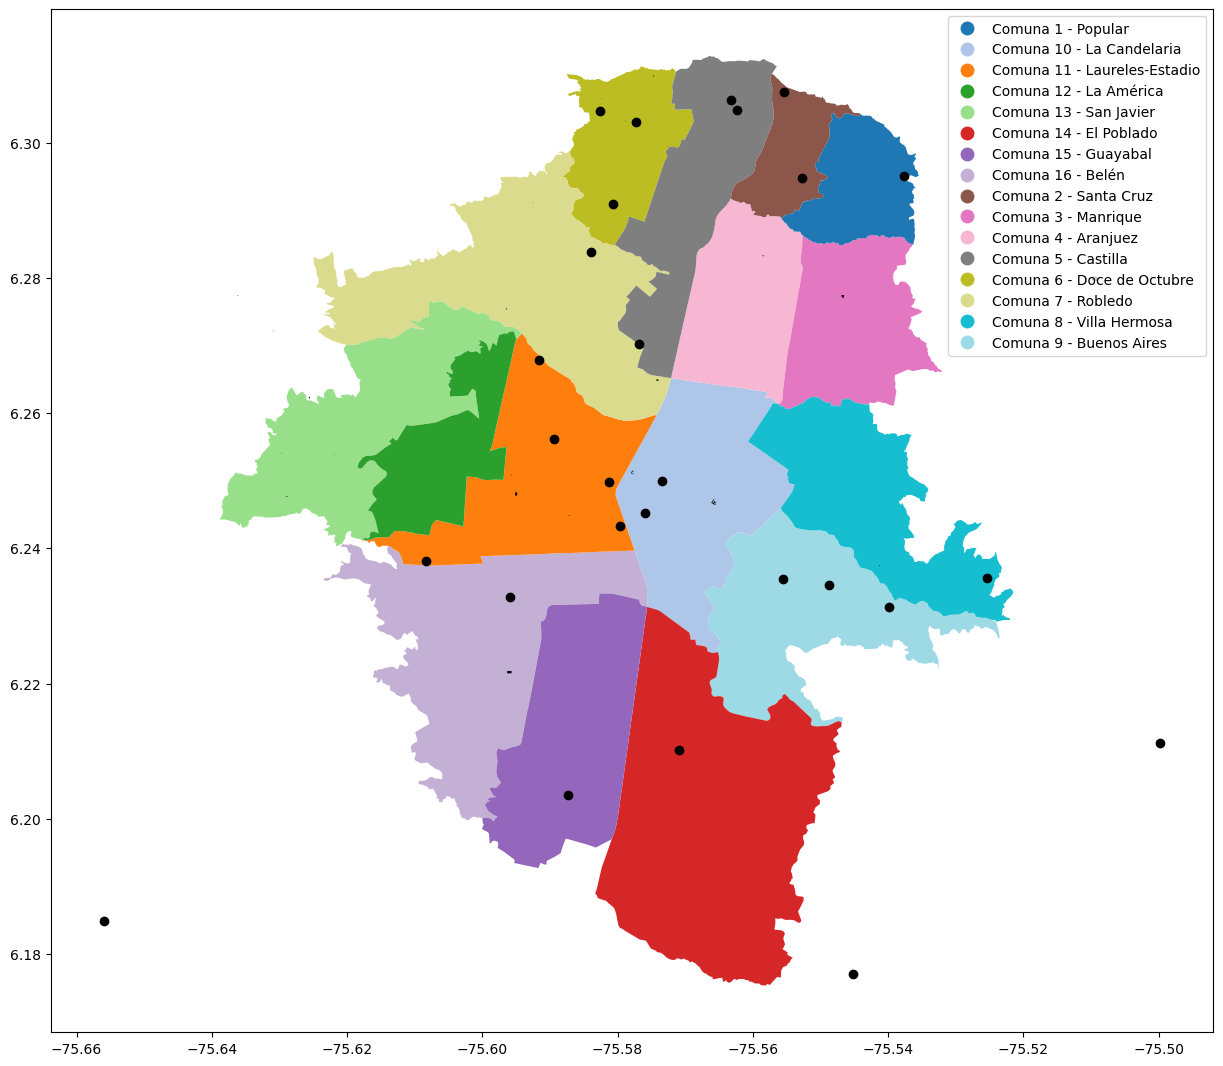

In [192]:
def plot_all():
    base = com_data.plot(column='name', legend=True, cmap='tab20', figsize=(15,30))
    pol_data.plot(ax=base, color='black')
# So far so good, but having those polygons is annoying
plot_all()

We have several problems with these:
- There are points outside of the relevant area.
- Some of the police stations are polygons rather than points.
- Some of the police stations do not have a name (not much to be done about it though)
- Some of the police stations are actually irrelevant (like schools)

### 2.1. Filtering out the police stations

In [193]:
pol_data = pol_data.loc[pol_data.within(com_data.union_all())]
pol_data

,geometry,amenity,name,opening_hours,operator,designation,addr:street,source,addr:city,addr:postcode,check_date,operator:wikidata,addr:housenumber,name:es,phone,building,operator:wikipedia
0,POINT (-75.55266 6.29474),police,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (-75.55541 6.30744),police,CAI El Playón,24/7,Policia Nacional de Colombia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (-75.58133 6.24981),police,CAI La Macarena,NaN,NaN,CAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (-75.55559 6.23541),police,CAI La Milagrosa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,POINT (-75.53992 6.23133),police,Estación de Policía Buenos Aires,NaN,Policía Nacional de Colombia,NaN,Calle 49,Kaart Ground Survey 2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,POINT (-75.5873 6.20355),police,CAI Guayabal,NaN,Policía Nacional de Colombia,NaN,Carrera 52,NaN,Medellín,050023,2024-05-04,NaN,NaN,NaN,NaN,NaN,NaN
7,POINT (-75.56319 6.30623),police,Escuela de Policía Carlos Holguín Mallarino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,POINT (-75.52535 6.23567),police,NaN,NaN,Policía Nacional,NaN,NaN,NaN,Comuna 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,POINT (-75.58391 6.28386),police,CAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,POINT (-75.53758 6.2951),police,CAI,NaN,Policía Nacional de Colombia,NaN,NaN,NaN,Comuna 1 - Popular,NaN,NaN,Q3394180,NaN,NaN,NaN,NaN,NaN


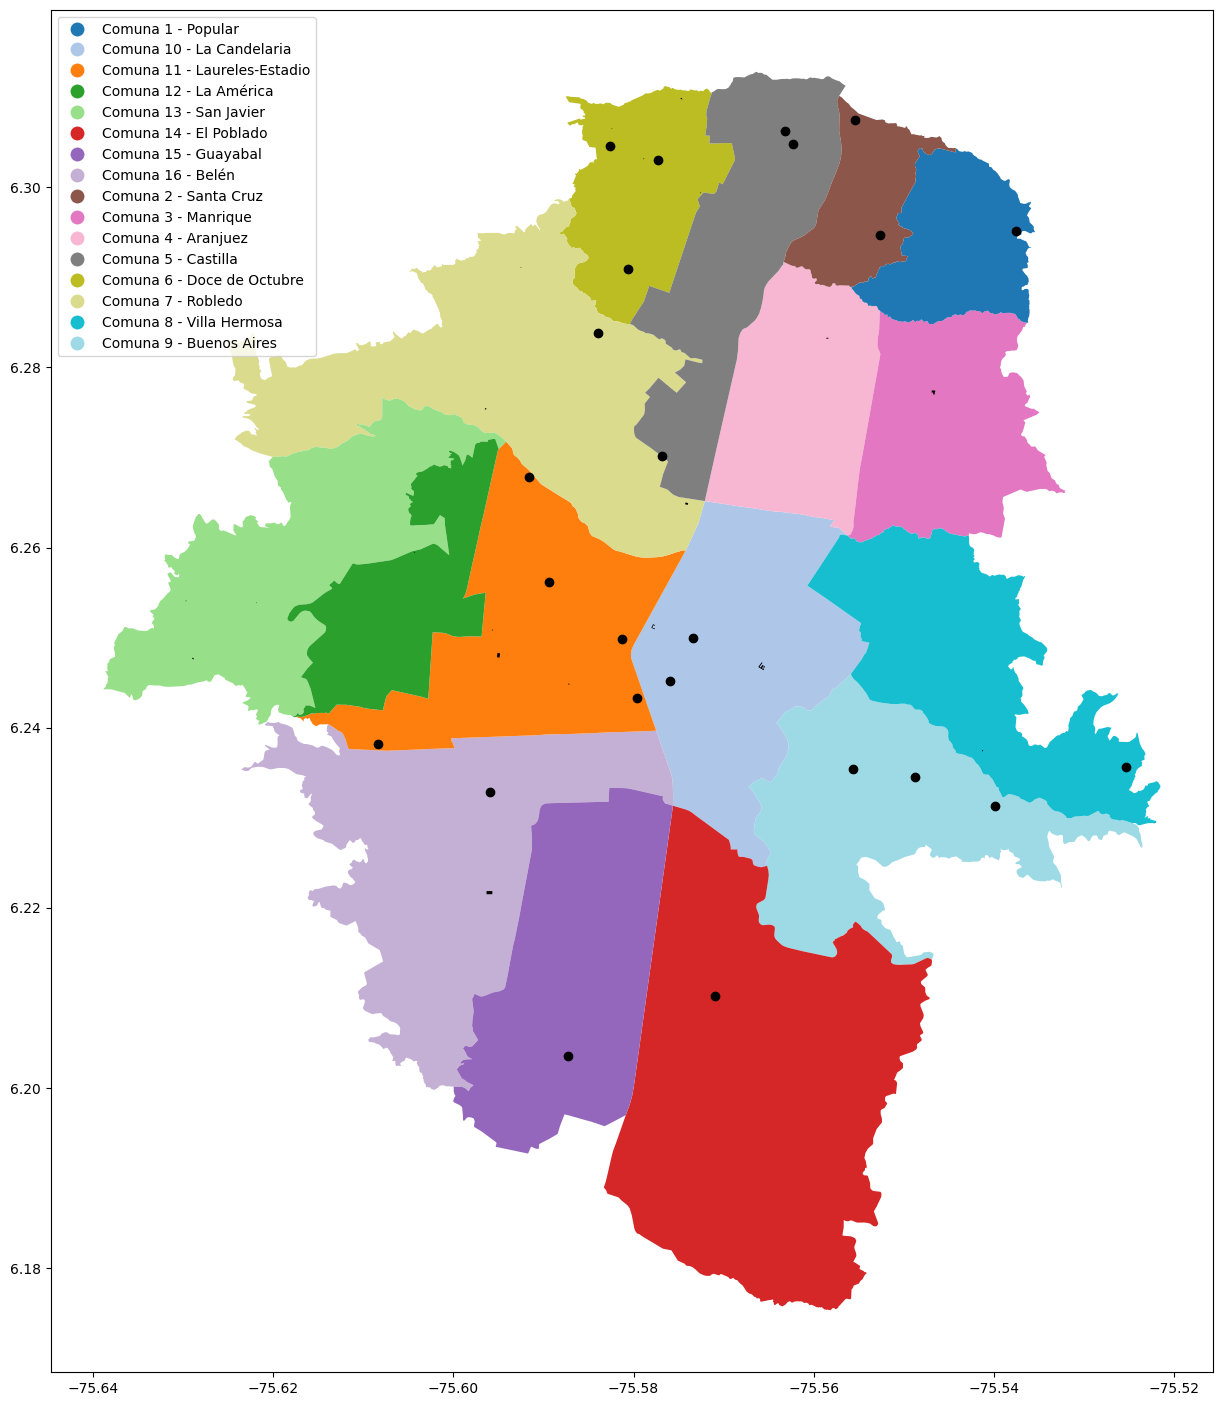

In [194]:
# Much better
plot_all()

In [195]:
not_include = ["militar", "escuela", "inspeccion", "familia", "turismo"]
pol_data = pol_data.loc[
    pol_data['name'].apply(lambda name: all((str(name).lower().find(word) < 0) for word in not_include))
]
pol_data

,geometry,amenity,name,opening_hours,operator,designation,addr:street,source,addr:city,addr:postcode,check_date,operator:wikidata,addr:housenumber,name:es,phone,building,operator:wikipedia
0,POINT (-75.55266 6.29474),police,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (-75.55541 6.30744),police,CAI El Playón,24/7,Policia Nacional de Colombia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (-75.58133 6.24981),police,CAI La Macarena,NaN,NaN,CAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (-75.55559 6.23541),police,CAI La Milagrosa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,POINT (-75.53992 6.23133),police,Estación de Policía Buenos Aires,NaN,Policía Nacional de Colombia,NaN,Calle 49,Kaart Ground Survey 2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,POINT (-75.5873 6.20355),police,CAI Guayabal,NaN,Policía Nacional de Colombia,NaN,Carrera 52,NaN,Medellín,050023,2024-05-04,NaN,NaN,NaN,NaN,NaN,NaN
8,POINT (-75.52535 6.23567),police,NaN,NaN,Policía Nacional,NaN,NaN,NaN,Comuna 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,POINT (-75.58391 6.28386),police,CAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,POINT (-75.53758 6.2951),police,CAI,NaN,Policía Nacional de Colombia,NaN,NaN,NaN,Comuna 1 - Popular,NaN,NaN,Q3394180,NaN,NaN,NaN,NaN,NaN
11,POINT (-75.56232 6.30476),police,Estación de Policía Castilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


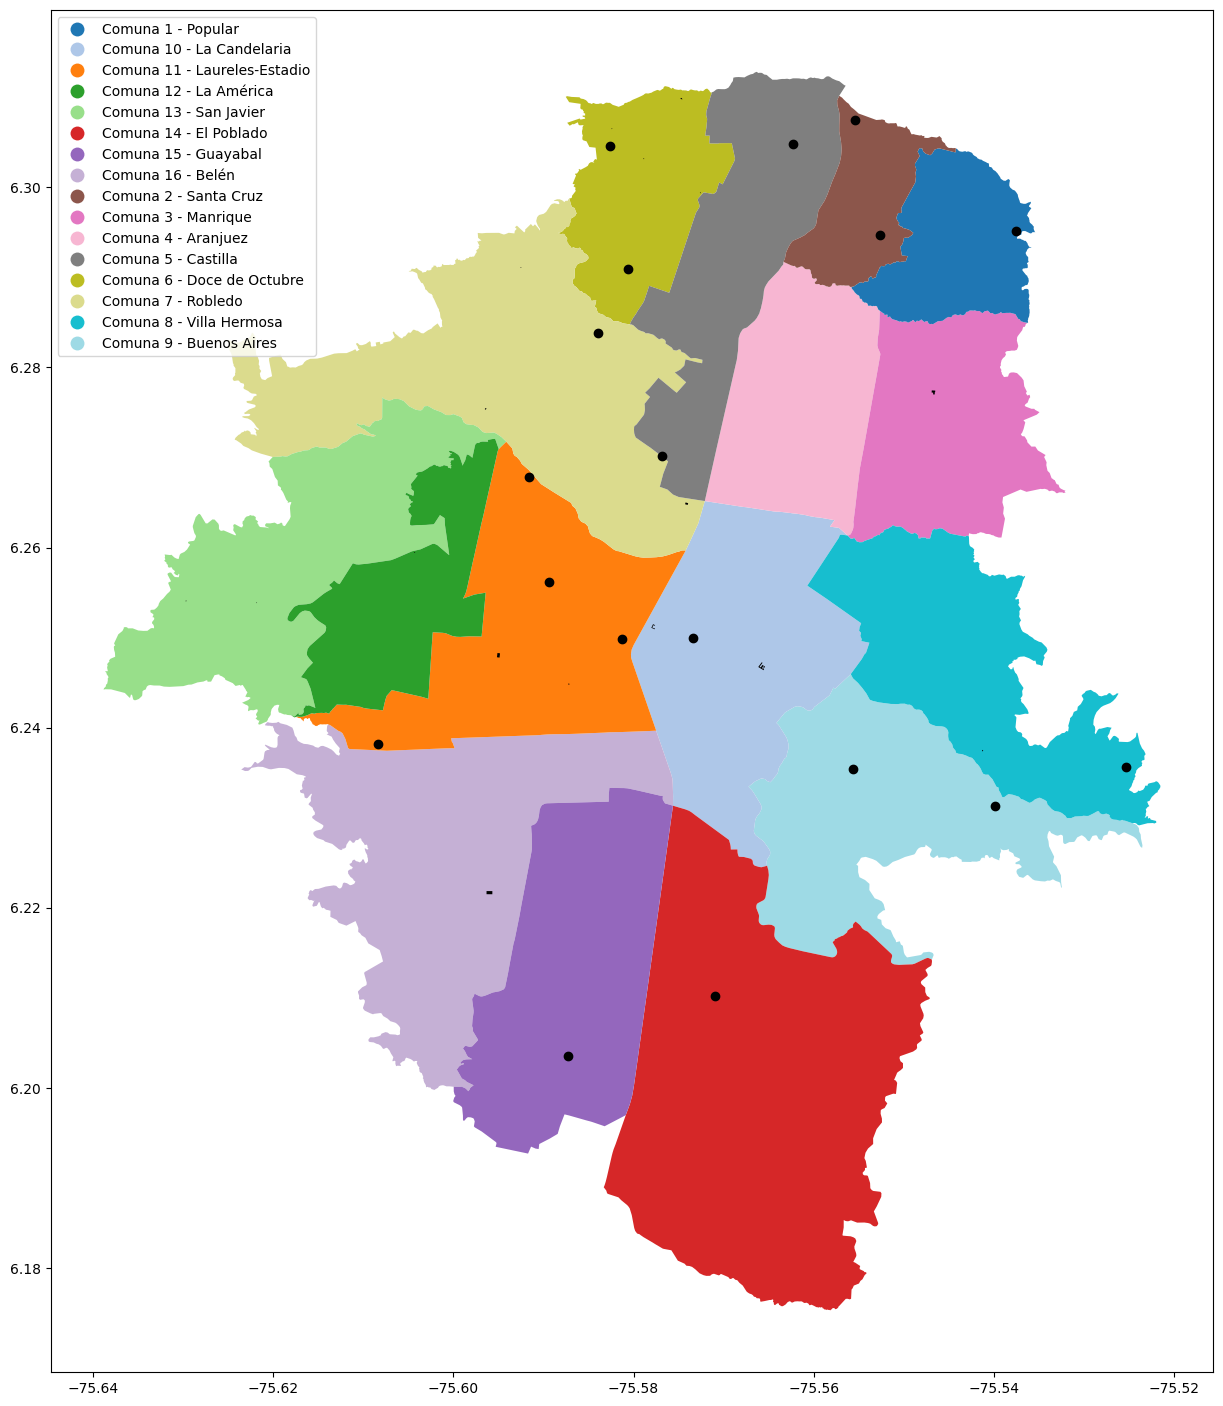

In [196]:
plot_all()

### 2.2. Polygons to points (finally)

In [197]:
pol_data.loc[:, 'geometry'] = pol_data.geometry.centroid
pol_data

,geometry,amenity,name,opening_hours,operator,designation,addr:street,source,addr:city,addr:postcode,check_date,operator:wikidata,addr:housenumber,name:es,phone,building,operator:wikipedia
0,POINT (-75.55266 6.29474),police,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (-75.55541 6.30744),police,CAI El Playón,24/7,Policia Nacional de Colombia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (-75.58133 6.24981),police,CAI La Macarena,NaN,NaN,CAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (-75.55559 6.23541),police,CAI La Milagrosa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,POINT (-75.53992 6.23133),police,Estación de Policía Buenos Aires,NaN,Policía Nacional de Colombia,NaN,Calle 49,Kaart Ground Survey 2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,POINT (-75.5873 6.20355),police,CAI Guayabal,NaN,Policía Nacional de Colombia,NaN,Carrera 52,NaN,Medellín,050023,2024-05-04,NaN,NaN,NaN,NaN,NaN,NaN
8,POINT (-75.52535 6.23567),police,NaN,NaN,Policía Nacional,NaN,NaN,NaN,Comuna 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,POINT (-75.58391 6.28386),police,CAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,POINT (-75.53758 6.2951),police,CAI,NaN,Policía Nacional de Colombia,NaN,NaN,NaN,Comuna 1 - Popular,NaN,NaN,Q3394180,NaN,NaN,NaN,NaN,NaN
11,POINT (-75.56232 6.30476),police,Estación de Policía Castilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


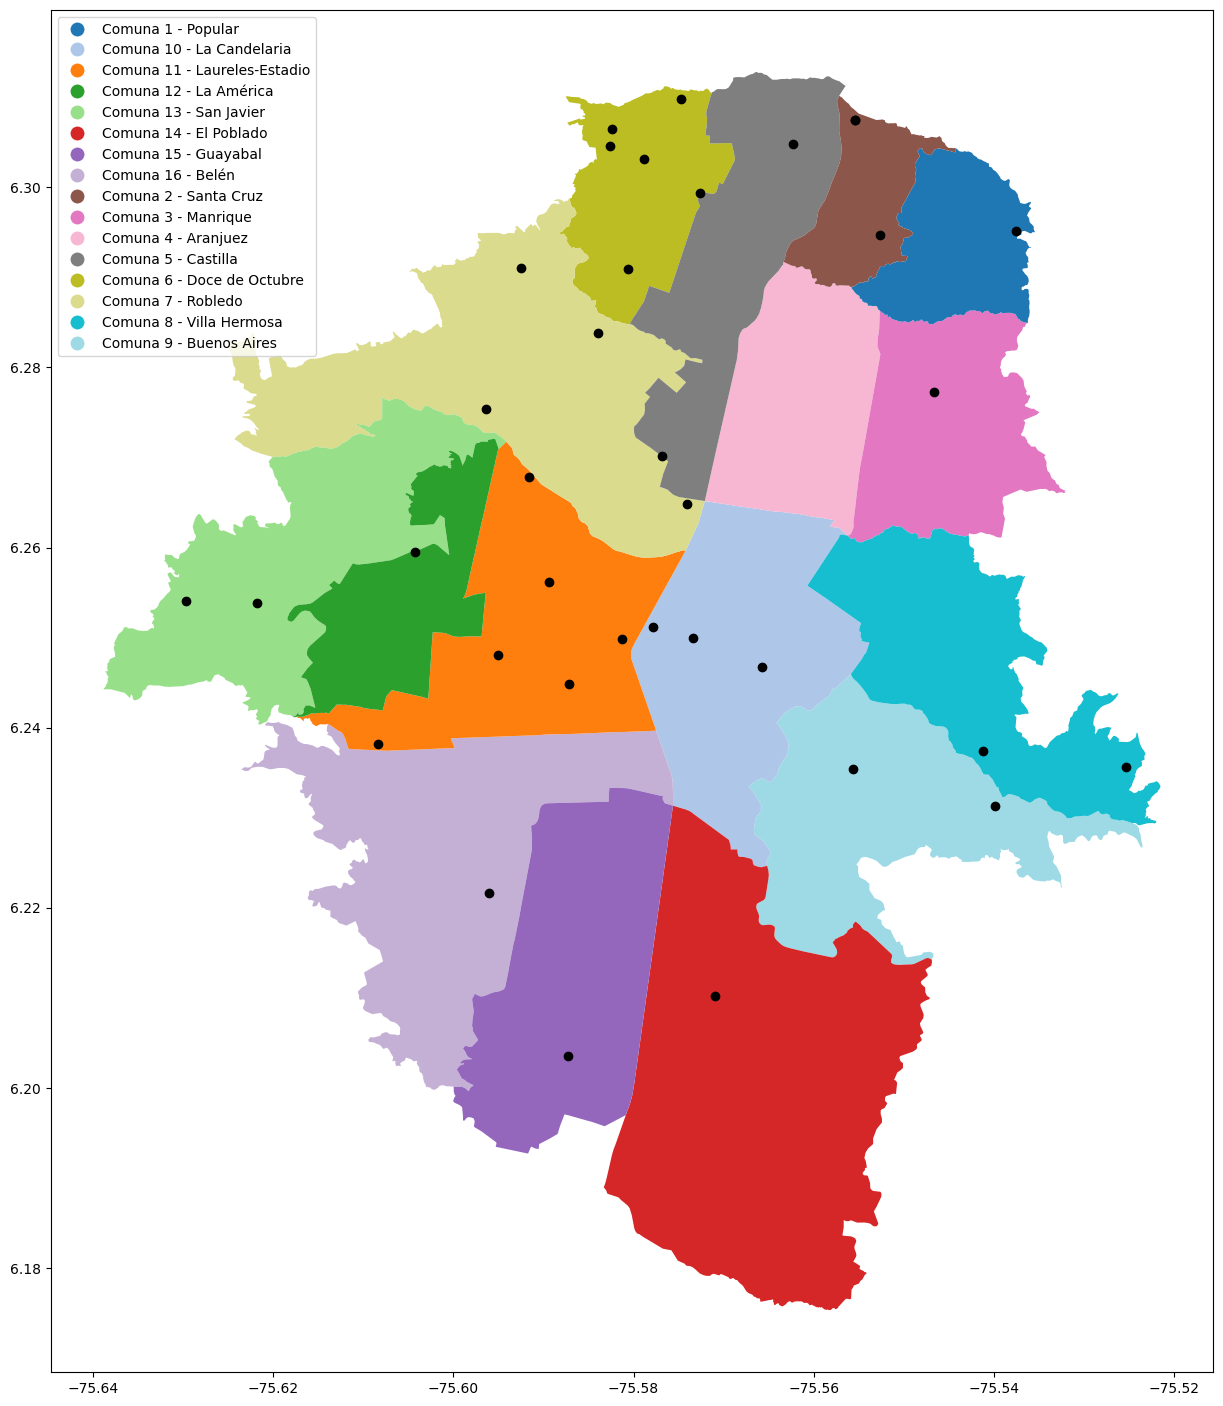

In [198]:
plot_all()

## 2.3. Renaming stations apropriately
Some stations are unnamed or named generically (e.g. CAI, POLICIA). We want to rename them according to the neighbourhood node closest to them.

In [199]:
from shapely.ops import nearest_points
def find_nearest(point):
    return barrios[barrios.geometry == nearest_points(point, barrios.union_all())[1]].iloc[0]


In [200]:
unnamed_stations = pol_data.loc[pol_data["name"].isnull() ^
        pol_data["name"].apply(lambda name: str(name).lower() in ('policia', 'cai'))
]

for index, station in unnamed_stations.iterrows():
    pol_data.loc[index, "name"] = "CAI " + find_nearest(station.geometry)["name"]
pol_data

,geometry,amenity,name,opening_hours,operator,designation,addr:street,source,addr:city,addr:postcode,check_date,operator:wikidata,addr:housenumber,name:es,phone,building,operator:wikipedia
0,POINT (-75.55266 6.29474),police,CAI Villa del Socorro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (-75.55541 6.30744),police,CAI El Playón,24/7,Policia Nacional de Colombia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (-75.58133 6.24981),police,CAI La Macarena,NaN,NaN,CAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (-75.55559 6.23541),police,CAI La Milagrosa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,POINT (-75.53992 6.23133),police,Estación de Policía Buenos Aires,NaN,Policía Nacional de Colombia,NaN,Calle 49,Kaart Ground Survey 2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,POINT (-75.5873 6.20355),police,CAI Guayabal,NaN,Policía Nacional de Colombia,NaN,Carrera 52,NaN,Medellín,050023,2024-05-04,NaN,NaN,NaN,NaN,NaN,NaN
8,POINT (-75.52535 6.23567),police,CAI La Sierra,NaN,Policía Nacional,NaN,NaN,NaN,Comuna 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,POINT (-75.58391 6.28386),police,CAI López de Mesa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,POINT (-75.53758 6.2951),police,CAI La Avanzada,NaN,Policía Nacional de Colombia,NaN,NaN,NaN,Comuna 1 - Popular,NaN,NaN,Q3394180,NaN,NaN,NaN,NaN,NaN
11,POINT (-75.56232 6.30476),police,Estación de Policía Castilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Writing the data
We'll write the data to `../geodata/`

In [201]:
com_data.to_file("../geodata/comunas.geojson")
pol_data.to_file("../geodata/police.geojson")

/home/fer/.cache/pypoetry/virtualenvs/backend-Xqoh8ZUo-py3.12/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
/home/fer/.cache/pypoetry/virtualenvs/backend-Xqoh8ZUo-py3.12/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
